In [3]:
import sqlite3

dbfile='viabill.db'

# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)

cur = con.cursor()

# The result of a "cursor.execute" can be iterated over by row
for row in cur.execute("SELECT * FROM "):
    print(row)

# Be sure to close the connection
con.close()

OperationalError: incomplete input

In [11]:
# loading in modules
import sqlite3

dbfile='viabill.db'

# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)

# creating cursor
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

# Be sure to close the connection
# con.close()

[('customers',), ('transactions',)]


In [12]:
table_list[0][0]

'customers'

In [14]:
for row in [acur.execute(f"SELECT * FROM {table_list[0][0]}"):
    print(row)

(1, 1, 25, '28 Irvine Place', '28 Irvine Place', None)
(2, 1, 19, '72 Bertha Street', '72 Bertha Street', 43200)
(3, 2, 22, '63 Ladberry Street', '63 Ladberry Street', 70200)
(4, 0, 24, '98 Linneman Close', '98 Linneman Close', 93900)
(5, 1, 53, '56 Salonica Road', '56 Salonica Road', 77000)
(6, 1, 69, '92 Purcell Lane', '92 Purcell Lane', 77500)
(7, 2, 29, '44 Trinity Street', '44 Trinity Street', 13600)
(8, 1, 64, '51 Allawah Road', '38 Cabrero Lane', 45200)
(9, 1, 52, '23 Bowen Terrace', '23 Bowen Terrace', 2700)
(10, 1, 53, '27 Kensington Way', '4 Azalea Street', 80000)
(11, 1, 49, '24 Spenlow Street', '24 Spenlow Street', 57000)
(12, 1, 59, '59 Wirra Circuit', '59 Wirra Circuit', 48400)
(13, 1, 62, '26 Elston Street', '26 Elston Street', 7800)
(14, 1, 23, '71 Merrick Street', '71 Merrick Street', 21200)
(15, 1, 63, '61 Cambrae Street', '61 Cambrae Street', 7500)
(16, 1, 79, '97 Moorland Street', '97 Moorland Street', 33100)
(17, 1, 46, '40 Townson Street', '40 Townson Street', 586

(3831, 1, 23, '12 Craig Street', '12 Craig Street', 98500)
(3832, 1, 63, '50 Couldrey Street', '50 Couldrey Street', 91400)
(3833, 2, 62, '84 Bartlett Street', '84 Bartlett Street', 48400)
(3834, 0, 59, '82 Gabwina Street', '82 Gabwina Street', 40800)
(3835, 1, 26, '88 Southampton Road', '88 Southampton Road', 26400)
(3836, 1, 25, '77 Nellie Street', '77 Nellie Street', 15600)
(3837, 1, 65, '21 Dahl Street', '', 8900)
(3838, 1, 67, '56 Dahlia Street', '56 Dahlia Street', 59300)
(3839, 1, 40, '80 Sheldon Street', '80 Sheldon Street', 73900)
(3840, 2, 24, '89 Woolner Place', '89 Woolner Place', 60100)
(3841, 1, 59, '28 Manooka Street', '28 Manooka Street', 54200)
(3842, 1, 49, '74 Bayliss Street', '74 Bayliss Street', 34700)
(3843, 2, 21, '87 Broadway Street', '87 Broadway Street', 61900)
(3844, 2, 23, '96 Iverna Street', '96 Iverna Street', 89100)
(3845, 1, 24, '50 Teefey Street', '50 Teefey Street', 51400)
(3846, 1, 51, '28 Wood Street', '28 Wood Street', 12600)
(3847, 1, 74, '88 Berth

(7141, 2, 51, '91 Lorinya Street', '91 Lorinya Street', 99900)
(7142, 2, 47, '11 Montague Road', '11 Montague Road', 60500)
(7143, 1, 56, '54 Woodland Street', '54 Woodland Street', 64500)
(7144, 1, 45, '25 Barrabui Street', '25 Barrabui Street', 1100)
(7145, 1, 17, '14 Glasshouse Crescent', '14 Glasshouse Crescent', 27900)
(7146, 2, 28, '25 Macklin Street', '25 Macklin Street', 19600)
(7147, 2, 59, '14 Asquith Street', '14 Asquith Street', 4400)
(7148, 1, 58, '79 Sugarmill Road', '79 Sugarmill Road', 56700)
(7149, 1, 49, '97 Persse Road', '97 Persse Road', 29800)
(7150, 1, 59, '70 Jefferis Street', '70 Jefferis Street', 51900)
(7151, 1, 62, '91 Lawler Street', '91 Lawler Street', None)
(7152, 1, 62, '28 Berrima Street', '28 Berrima Street', 29300)
(7153, 1, 56, '12 Cowper Street', '12 Cowper Street', 10000)
(7154, 2, 54, '44 Chermside Street', '44 Chermside Street', None)
(7155, 1, 43, '32 Carl Street', '32 Carl Street', 64000)
(7156, 2, 55, '42 Pamela Street', '42 Pamela Street', 296

(10388, 1, 23, '78 Love Street', '78 Love Street', 60800)
(10389, 1, 47, '9 Abercrombie Street', '9 Abercrombie Street', 52200)
(10390, 1, 52, '31 Quaver Court', '31 Quaver Court', 36300)
(10391, 1, 24, '62 Hickory Close', '18 Falkland Street', 6000)
(10392, 2, 20, '22 Shelley Street', '22 Shelley Street', 13000)
(10393, 1, 26, '5 Hillhouse Street', '5 Hillhouse Street', 92800)
(10394, 1, 21, '82 Corbett Street', '82 Corbett Street', 18100)
(10395, 2, 24, '27 Pickering Place', '27 Pickering Place', 62700)
(10396, 1, 59, '71 Perwell Street', '71 Perwell Street', 92200)
(10397, 1, 60, '69 Eve Street', '69 Eve Street', 17200)
(10398, 1, 41, '69 Meadfoot Road', '69 Meadfoot Road', 21300)
(10399, 1, 54, '33 Fiesole Place', '33 Fiesole Place', 81000)
(10400, 1, 28, '31 Erroll Street', '31 Erroll Street', 58500)
(10401, 1, 27, '87 Gooderham Road', '87 Gooderham Road', 81000)
(10402, 1, 58, '56 Peterleen Street', '56 Peterleen Street', 95000)
(10403, 1, 56, '3 Victoria Close', '3 Victoria Clos

(13880, 1, 56, '70 Dorville Road', '70 Dorville Road', 17300)
(13881, 1, 26, '41 Kroshanne Street', '41 Kroshanne Street', 600)
(13882, 1, 59, '24 Tristan Street', '24 Tristan Street', 55200)
(13883, 1, 65, '86 Clausen Street', '86 Clausen Street', 81800)
(13884, 1, 48, "48 O'neil Street", "48 O'neil Street", 98600)
(13885, 1, 18, '82 Calonne Street', '82 Calonne Street', 92300)
(13886, 1, 52, '39 Landseer Street', '39 Landseer Street', 71400)
(13887, 2, 63, '43 Acanthus Street', '43 Acanthus Street', 35400)
(13888, 1, 58, '45 Montana Place', '45 Montana Place', 800)
(13889, 1, 28, '53 Kestrel Street', '53 Kestrel Street', 19400)
(13890, 1, 48, '68 Waitara Street', '68 Waitara Street', 12600)
(13891, 2, 19, '43 Bushlark Street', '43 Bushlark Street', 20300)
(13892, 1, 25, '79 Mollison Street', '', 15800)
(13893, 1, 46, '62 Charles Place', '62 Charles Place', 15500)
(13894, 2, 53, '79 Park Street', '79 Park Street', 39900)
(13895, 1, 52, '78 Ardennes Close', '78 Ardennes Close', 58400)


(16596, 2, 50, '85 Armfield Street', '85 Armfield Street', 49700)
(16597, 1, 21, '88 Orari Road', '88 Orari Road', 18900)
(16598, 1, 21, '33 Melanie Street', '', 39400)
(16599, 1, 62, '19 Corrofin Street', '19 Corrofin Street', 66500)
(16600, 1, 49, '31 Supreme Street', '31 Supreme Street', 30900)
(16601, 2, 65, '74 Ridley Street', '74 Ridley Street', 48600)
(16602, 1, 40, '72 Kauri Road', '72 Kauri Road', 16000)
(16603, 2, 20, '36 Halifax Street', '36 Halifax Street', 12900)
(16604, 1, 78, '48 Kingsford Street', '48 Kingsford Street', 99600)
(16605, 1, 54, '83 Maria Lane', '83 Maria Lane', 74600)
(16606, 1, 34, '29 Octave Court', '29 Octave Court', 58600)
(16607, 1, 30, '49 Rock Street', '49 Rock Street', 28100)
(16608, 1, 30, '58 Laura Street', '58 Laura Street', 6400)
(16609, 1, 50, '98 Kooralgin Street', '98 Kooralgin Street', 12200)
(16610, 1, 27, '16 Talltrees Circuit', '16 Talltrees Circuit', 51300)
(16611, 1, 60, '46 Mitchell Street', '46 Mitchell Street', 9700)
(16612, 2, 56, 

(19501, 1, 63, '23 Kirkley Street', '87 Gona Parade', 60000)
(19502, 2, 61, '45 Larch Street', '45 Larch Street', 5100)
(19503, 1, 27, '100 Brokenwood Circuit', '100 Brokenwood Circuit', 22300)
(19504, 1, 43, '40 Sway Street', '40 Sway Street', 39000)
(19505, 0, 17, '60 Hicks Street', '60 Hicks Street', 56300)
(19506, 1, 21, '35 Koolewong Street', '35 Koolewong Street', 99800)
(19507, 1, 43, '1 Tilley Road', '1 Tilley Road', 81300)
(19508, 1, 62, '59 Ironbark Road', '59 Ironbark Road', 11900)
(19509, 0, 30, '14 Goorna Close', '14 Goorna Close', 24000)
(19510, 2, 22, '42 Scarlet oak Place', '42 Scarlet oak Place', 54200)
(19511, 1, 59, '21 Duke Street', '21 Duke Street', 7600)
(19512, 1, 20, '74 Eagle Lane', '74 Eagle Lane', 8600)
(19513, 0, 49, '71 Azalea Crescent', '71 Azalea Crescent', 32700)
(19514, 1, 55, '3 Vivian Street', '3 Vivian Street', 33400)
(19515, 1, 22, '24 Nevern Street', '24 Nevern Street', 67600)
(19516, 1, 19, '11 Brassey Street', '11 Brassey Street', 1400)
(19517, 2

(22453, 2, 28, '98 Marshall Place', '98 Marshall Place', 42700)
(22454, 2, 50, '86 Daintree Drive', '', 25500)
(22455, 1, 56, '54 Riverina Street', '54 Riverina Street', 92000)
(22456, 1, 50, '40 Anderson Street', '40 Anderson Street', 42100)
(22457, 1, 65, '61 Snowbird Place', '61 Snowbird Place', 75600)
(22458, 2, 28, '60 Desgrand Street', '60 Desgrand Street', 62100)
(22459, 1, 28, '30 Chapel hill Road', '30 Chapel hill Road', 55700)
(22460, 1, 27, '12 Elton Street', '12 Elton Street', 48800)
(22461, 1, 46, '69 Wedgetail Street', '69 Wedgetail Street', 48900)
(22462, 1, 55, '34 Rainwood Street', '34 Rainwood Street', 8600)
(22463, 1, 73, '2 Cornucopia Street', '2 Cornucopia Street', 80000)
(22464, 1, 33, '14 Grays Road', '14 Grays Road', 20700)
(22465, 1, 67, '27 Eppalong Street', '27 Eppalong Street', 24900)
(22466, 2, 23, '84 Kalinga Street', '', 78600)
(22467, 1, 44, '36 Illabo Court', '36 Illabo Court', 17100)
(22468, 1, 80, '69 Barrygroves Court', '69 Barrygroves Court', 63100)

(25658, 1, 62, '39 Whipbird Place', '39 Whipbird Place', 83700)
(25659, 2, 29, '71 Cara Street', '71 Cara Street', 81000)
(25660, 1, 17, '81 Alderson Street', '81 Alderson Street', 80400)
(25661, 2, 55, '32 Blackheath Avenue', '32 Blackheath Avenue', 57100)
(25662, 1, 52, '43 Emu Place', '43 Emu Place', 3100)
(25663, 2, 49, '5 Oakleaf Street', '5 Oakleaf Street', 64600)
(25664, 1, 18, '27 Hodge Street', '27 Hodge Street', 84300)
(25665, 1, 24, '27 Bond Street', '27 Bond Street', 7900)
(25666, 1, 21, '58 Acorus Place', '58 Acorus Place', 49100)
(25667, 1, 58, '2 Anatini Place', '2 Anatini Place', 64000)
(25668, 1, 73, '6 Thanbarran Place', '6 Thanbarran Place', 2700)
(25669, 2, 56, '87 Thynne Road', '87 Thynne Road', 90200)
(25670, 1, 52, '9 Ormonde Road', '9 Ormonde Road', 17200)
(25671, 1, 61, '69 Warrumbungle Parade', '69 Warrumbungle Parade', 39400)
(25672, 1, 40, '79 Leicester Street', '79 Leicester Street', 7700)
(25673, 2, 25, '51 Leone Street', '51 Leone Street', 57900)
(25674, 

(28422, 2, 52, '76 Dartnell Street', '76 Dartnell Street', None)
(28423, 2, 81, '26 Marshall Street', '26 Marshall Street', 43300)
(28424, 1, 49, '93 Susan Street', '93 Susan Street', 58400)
(28425, 1, 57, '68 Gruner Street', '68 Gruner Street', 96200)
(28426, 1, 41, '38 Greer Street', '38 Greer Street', 15200)
(28427, 2, 58, '34 Loughrea Street', '34 Loughrea Street', 9800)
(28428, 1, 58, '1 Burlington Street', '1 Burlington Street', 84700)
(28429, 1, 22, '84 Queens Parade', '84 Queens Parade', 43500)
(28430, 2, 20, '75 Billanook Close', '75 Billanook Close', 7100)
(28431, 1, 56, '26 Beatson Terrace', '61 Cassia Street', 53700)
(28432, 1, 62, '52 Cross Street', '52 Cross Street', 25200)
(28433, 2, 31, '80 Pleasant Street', '80 Pleasant Street', 79000)
(28434, 1, 23, '32 Woombye Street', '32 Woombye Street', 10000)
(28435, 1, 68, '45 Pearse Street', '45 Pearse Street', 36200)
(28436, 2, 26, '76 Salkeld Street', '76 Salkeld Street', 28200)
(28437, 1, 52, '84 Terowi Street', '84 Terowi S

(31403, 1, 38, '93 Hare Street', '93 Hare Street', 87100)
(31404, 1, 18, '84 Mailey Street', '84 Mailey Street', 19400)
(31405, 1, 63, '67 Kaye Street', '67 Kaye Street', 16400)
(31406, 1, 49, '70 Gristock Street', '70 Gristock Street', 26200)
(31407, 0, 23, '26 Twilight Street', '26 Twilight Street', 24600)
(31408, 2, 17, '90 Kooyong Court', '90 Kooyong Court', 61000)
(31409, 1, 30, '90 Phoenix Street', '90 Phoenix Street', 33500)
(31410, 1, 51, '29 Leewin Court', '29 Leewin Court', 98800)
(31411, 2, 67, '97 Mahogany Place', '97 Mahogany Place', 26000)
(31412, 0, 21, '35 Tenth Avenue', '35 Tenth Avenue', 27800)
(31413, 1, 52, '7 Roseneath Parade', '7 Roseneath Parade', 82200)
(31414, 1, 55, '25 Barramul Street', '25 Barramul Street', None)
(31415, 1, 62, '43 Larch Street', '43 Larch Street', 14200)
(31416, 1, 47, '15 Alloa Street', '15 Alloa Street', 54300)
(31417, 1, 45, '23 Hampshire Court', '23 Hampshire Court', 1900)
(31418, 1, 60, '56 Hopgood Street', '56 Hopgood Street', 79100)


(34458, 1, 61, '43 Lillydale Place', '43 Lillydale Place', 94700)
(34459, 2, 25, '78 Sheridan Street', '96 Station Road', 50100)
(34460, 1, 48, '50 Edmond Street', '50 Edmond Street', 45800)
(34461, 1, 26, '58 Tilley Road', '58 Tilley Road', 71600)
(34462, 2, 54, '2 Beaufort Court', '2 Beaufort Court', 7300)
(34463, 2, 47, '13 Minnipa Street', '13 Minnipa Street', 33900)
(34464, 1, 46, '93 Doyle Place', '93 Doyle Place', 54200)
(34465, 1, 20, '34 Salisbury Street', '34 Salisbury Street', 25800)
(34466, 1, 56, '31 Macarthur Court', '31 Macarthur Court', 38400)
(34467, 1, 49, '50 Imperial Avenue', '50 Imperial Avenue', 55900)
(34468, 1, 47, '3 Duff Street', '3 Duff Street', 3000)
(34469, 1, 53, '3 Altandi Street', '3 Altandi Street', 40700)
(34470, 1, 26, '52 Dollis Street', '52 Dollis Street', 39000)
(34471, 1, 53, '7 Conn Street', '7 Conn Street', 9600)
(34472, 1, 23, '9 Ferndale Street', '9 Ferndale Street', 48300)
(34473, 1, 20, '82 Ryecroft Place', '82 Ryecroft Place', 96300)
(34474

(37365, 2, 68, '92 Fife Street', '92 Fife Street', 56600)
(37366, 1, 49, '63 Macansh Street', '63 Macansh Street', None)
(37367, 1, 55, '14 Overlord Place', '14 Overlord Place', 20900)
(37368, 1, 45, '57 Yale Street', '57 Yale Street', 26400)
(37369, 1, 63, '30 Aberdeen Place', '30 Aberdeen Place', 94500)
(37370, 1, 24, '40 Stain Street', '40 Stain Street', 85200)
(37371, 1, 19, '41 Ellerdale Street', '41 Ellerdale Street', None)
(37372, 1, 52, '64 Collier Street', '64 Collier Street', 4600)
(37373, 1, 42, '27 Honeywood Street', '27 Honeywood Street', 20400)
(37374, 1, 30, '96 Stanley Street', '96 Stanley Street', 17400)
(37375, 1, 66, '32 Tara Street', '32 Tara Street', 61200)
(37376, 2, 49, '10 Keith Street', '10 Keith Street', 74600)
(37377, 1, 53, '89 Villiers Street', '89 Villiers Street', 44600)
(37378, 0, 59, '2 Waratah Street', '2 Waratah Street', 67600)
(37379, 1, 57, '54 Pressland Street', '44 Old cleveland Road', 91500)
(37380, 1, 24, '27 Ingham Street', '27 Ingham Street', 

(40111, 1, 73, '34 Craig Street', '34 Craig Street', 8700)
(40112, 2, 51, '41 Holland Street', '41 Holland Street', 22300)
(40113, 1, 31, '75 Fathom Close', '75 Fathom Close', 23900)
(40114, 2, 52, '80 Bathgate Street', '80 Bathgate Street', 98100)
(40115, 2, 55, '33 Gaddes Place', '33 Gaddes Place', 39700)
(40116, 1, 24, '36 Savoy Street', '36 Savoy Street', 56100)
(40117, 2, 54, '1 Lydia Street', '1 Lydia Street', 41300)
(40118, 1, 25, '64 Meldrum Street', '64 Meldrum Street', 15200)
(40119, 2, 56, '59 Bening Place', '59 Bening Place', 11800)
(40120, 2, 53, '6 Pedley Street', '6 Pedley Street', 27400)
(40121, 2, 48, '91 Nursery Street', '91 Nursery Street', 35200)
(40122, 1, 49, '74 Daintree Drive', '74 Daintree Drive', 95300)
(40123, 1, 21, '1 Cherry Street', '1 Cherry Street', 2900)
(40124, 1, 53, '13 Kyoomba Street', '13 Kyoomba Street', 30400)
(40125, 1, 52, '79 Peck Street', '79 Peck Street', 20900)
(40126, 1, 24, '51 Benedict Street', '51 Benedict Street', 66400)
(40127, 1, 52,

(43080, 1, 48, '51 Zambesi Street', '51 Zambesi Street', 78100)
(43081, 1, 40, '65 Lewis Place', '65 Lewis Place', 52400)
(43082, 2, 58, '71 Minard Street', '71 Minard Street', 47700)
(43083, 0, 28, '57 Hurst Street', '57 Hurst Street', 82800)
(43084, 2, 44, '43 Greenlaw Street', '43 Greenlaw Street', 81700)
(43085, 1, 62, '79 Upper kedron Road', '79 Upper kedron Road', 74600)
(43086, 1, 55, '58 Camberwell Street', '58 Camberwell Street', 2300)
(43087, 1, 19, '15 Newmarket Road', '15 Newmarket Road', 31600)
(43088, 1, 23, '95 Goskar Avenue', '95 Goskar Avenue', 78600)
(43089, 1, 52, '17 Cassimaty Street', '17 Cassimaty Street', 80100)
(43090, 1, 62, '31 Lydford Court', '31 Lydford Court', 81800)
(43091, 1, 51, '44 Belmore Street', '44 Belmore Street', 24900)
(43092, 2, 20, '63 Boundary Road', '63 Boundary Road', 48900)
(43093, 1, 27, '31 Pickering Street', '31 Pickering Street', None)
(43094, 1, 56, '93 Murray Street', '93 Murray Street', 52000)
(43095, 2, 55, '55 Killarney Place', '55

(46291, 2, 67, '29 Coulter Crescent', '29 Coulter Crescent', 92200)
(46292, 2, 40, '14 Foxhill Street', '14 Foxhill Street', 42500)
(46293, 1, 28, '21 Edith Street', '91 Staghorn Street', 48700)
(46294, 1, 62, '8 Greenfield Place', '8 Greenfield Place', 27500)
(46295, 1, 53, '32 Pegasus Street', '32 Pegasus Street', 64200)
(46296, 1, 60, '97 Ardoch Street', '97 Ardoch Street', 11000)
(46297, 1, 35, '61 Connaught Street', '61 Connaught Street', 95600)
(46298, 0, 41, '12 New Road', '12 New Road', 70500)
(46299, 0, 50, '85 Pictum Place', '85 Pictum Place', 91100)
(46300, 1, 52, '23 Cagney Street', '23 Cagney Street', 61600)
(46301, 1, 50, '83 Gumdale Street', '83 Gumdale Street', 15900)
(46302, 1, 25, '97 St pauls Terrace', '97 St pauls Terrace', 26600)
(46303, 2, 32, '38 Gaynor Road', '38 Gaynor Road', 95700)
(46304, 1, 57, '24 Cordia Street', '24 Cordia Street', 5000)
(46305, 1, 46, '56 Tallara Street', '56 Tallara Street', 50700)
(46306, 2, 40, '45 Arunta Street', '45 Arunta Street', 1

KeyboardInterrupt: 

In [18]:
df = spark.read.format("jdbc").options(url='<url>',
                                       dbtable='<tablename>',
                                       driver="org.sqlite.JDBC",
                                       customSchema="<col1> DECIMAL(38, 0), <col2> DECIMAL(38, 0), <col3> DECIMAL(38, 0)").load()`

SyntaxError: invalid syntax (Temp/ipykernel_16808/899765130.py, line 4)

In [21]:
!pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812390 sha256=b639b1a98bbd1b7e90707f2ad41a19f12834559d7d2591b3c5a9c1ca6687a6f7
  Stored in directory: c:\users\km728\appdata\local\pip\cache\wheels\11\67\ea\33c283e520b775aa7a7a0d404447e287be841a711d074d4d91
Successfully built pyspark


In [23]:
import pyspark
import 

In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
           .config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.35.5')\
           .getOrCreate()

# customers = spark.read.format('jdbc') \
#             .options(driver='org.sqlite.JDBC', dbtable='customers',
#             url='jdbc:sqlite:viabill.db')\
#             .load()

# transactions = spark.read.format('jdbc') \
#             .options(driver='org.sqlite.JDBC', dbtable='customers',
#             url='jdbc:sqlite:viabill.db')\
#             .load()

KeyboardInterrupt: 

In [102]:
import sqlite3
import pandas as pd

# Create your connection.
cnx = sqlite3.connect('viabill.db')

customers = pd.read_sql_query("SELECT * FROM CUSTOMERS", cnx)

transactions = pd.read_sql_query("SELECT * FROM TRANSACTIONS", cnx)

In [103]:
customers

,customerID,sex,age,residentialAddress,postalAddress,income
0,1,1,25,28 Irvine Place,28 Irvine Place,NaN
1,2,1,19,72 Bertha Street,72 Bertha Street,43200.0
2,3,2,22,63 Ladberry Street,63 Ladberry Street,70200.0
3,4,0,24,98 Linneman Close,98 Linneman Close,93900.0
4,5,1,53,56 Salonica Road,56 Salonica Road,77000.0
...,...,...,...,...,...,...
499995,499996,1,68,95 Argyle Parade,95 Argyle Parade,40500.0
499996,499997,2,22,34 Bearke Place,34 Bearke Place,44900.0
499997,499998,1,27,95 Glenhurst Street,95 Glenhurst Street,48700.0
499998,499999,1,55,34 Kiandra Close,34 Kiandra Close,7600.0


In [104]:
transactions

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4
0,1,114,2869,140,0,0,0,0
1,2,855,124077,70,0,0,0,0
2,3,752,86184,85,0,0,0,0
3,4,246,248861,43,1,0,0,0
4,5,973,162112,127,0,0,0,0
...,...,...,...,...,...,...,...,...
1999995,1999996,758,333312,12,0,0,1,1
1999996,1999997,932,31802,145,0,2,2,2
1999997,1999998,932,449391,19,0,0,0,0
1999998,1999999,878,433902,198,0,1,0,0


In [105]:
# task 1:

# the last transaction data of each client as credit application data

credit_applications=transactions.drop_duplicates(subset='customerID',keep='last')

# join credit_applications data with income from customers table

credit_applications=credit_applications.merge(customers[['customerID','income']],on='customerID',how='left')
credit_applications['income'].fillna(-999,inplace=True)

# task 2, feature engineering: average price of the previous 3 transactions

transactions['price_lag1'] = transactions.groupby('customerID')['price'].shift(1)
transactions['price_lag2'] = transactions.groupby('customerID')['price'].shift(2)
transactions['price_lag3'] = transactions.groupby('customerID')['price'].shift(3)
transactions['price_avg_lst3'] = transactions[['price_lag1','price_lag2','price_lag3']].mean(axis=1,skipna=False)

credit_applications=credit_applications.merge(transactions[['customerID','transactionID','price_avg_lst3']],on=['customerID','transactionID'],how='left')

In [106]:
# task3, statistical test

from scipy.stats import ttest_ind, f_oneway

# let us check subpopulations of customers with respect to sex variable
print(customers['sex'].value_counts(dropna=False))

# there are three significantly large subsamples divided with respect to sex
# one should perform one way F-ANOVA test to infer about the dependency between age ("continuous") and sex (treated as categorical)
# H0: the mean age in all 3 groups are equal
anova_stat, anova_pvalue = f_oneway(customers[customers['sex']==0]['age'].to_numpy(),customers[customers['sex']==1]['age'].to_numpy(),customers[customers['sex']==2]['age'].to_numpy())

alpha=0.05
if (anova_pvalue<alpha):
    print(f'At significance level={alpha}, H1 is accepted - hence, there are differences in average age levels between subpopulations of different sex')
else:
    print(f'At significance level={alpha}, there is no reason to reject H0 saying that average age level is the same between subpopulations of different sex')
# no reason to reject H0 at significance level=0.05

1    374545
2    100328
0     25127
Name: sex, dtype: int64
At significance level=0.05, there is no reason to reject H0 saying that average age level is the same between subpopulations of different sex


In [107]:
# credit_applications

sum(customers.duplicated())
sum(transactions.duplicated())

history=pd.concat([transactions[['customerID','transactionID']],credit_applications[['customerID','transactionID']]]).drop_duplicates(keep=False)

history=history.merge(transactions,on=['customerID','transactionID'],how='inner')
history['worst_paymentstatus1']=history.groupby('customerID')['paytmentStatus1'].transform(max)
history['worst_paymentstatus2']=history.groupby('customerID')['paytmentStatus2'].transform(max)
history['worst_paymentstatus3']=history.groupby('customerID')['paytmentStatus3'].transform(max)
history['worst_paymentstatus4']=history.groupby('customerID')['paytmentStatus4'].transform(max)
history['count']=history.groupby('customerID')['price'].count()
history['worst_paymentstatus_all']=history[['worst_paymentstatus1','worst_paymentstatus2','worst_paymentstatus3','worst_paymentstatus4']].max(axis=1)
history=history.drop_duplicates(subset='customerID')
credit_applications=credit_applications.merge(history[['customerID','worst_paymentstatus1','worst_paymentstatus2','worst_paymentstatus3','worst_paymentstatus4','worst_paymentstatus_all','count']],on='customerID',how='left')
credit_applications

# x=transactions[~transactions.apply(tuple,1).isin(credit_applications.apply(tuple,1))]
# x

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,income,price_avg_lst3,worst_paymentstatus1,worst_paymentstatus2,worst_paymentstatus3,worst_paymentstatus4,worst_paymentstatus_all,count
0,76,396,330502,49,0,0,0,0,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,113,654,44827,152,1,0,0,0,31600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,159,842,113005,5,0,0,0,0,28600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,177,555,239588,174,0,1,0,0,95100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181,530,485126,194,0,0,0,0,62200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490529,1999996,758,333312,12,0,0,1,1,4200.0,84.000000,0.0,0.0,1.0,1.0,1.0,NaN
490530,1999997,932,31802,145,0,2,2,2,48200.0,117.666667,0.0,0.0,0.0,0.0,0.0,4.0
490531,1999998,932,449391,19,0,0,0,0,100.0,71.000000,2.0,2.0,2.0,2.0,2.0,NaN
490532,1999999,878,433902,198,0,1,0,0,17900.0,114.666667,0.0,0.0,0.0,1.0,1.0,5.0


In [113]:
credit_applications['price_avg_lst3'].fillna(credit_applications['price_avg_lst3'].mean(),inplace=True)
credit_applications['worst_paymentstatus1'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus2'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus3'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus4'].fillna(-1,inplace=True)
credit_applications['worst_paymentstatus_all'].fillna(-1,inplace=True)
credit_applications['count'].fillna(0,inplace=True)

In [120]:
# data=credit_applications[['shopID','price','worst_paymentstatus_all','worst_paymentstatus1','worst_paymentstatus2','worst_paymentstatus3','worst_paymentstatus4','price_avg_lst3']]
data=credit_applications[['price','worst_paymentstatus_all','worst_paymentstatus1','price_avg_lst3','count']]

data=(data-data.mean())/(data.std())

In [121]:
from sklearn.cluster import KMeans

1
2
3
4
5
6
7
8
9


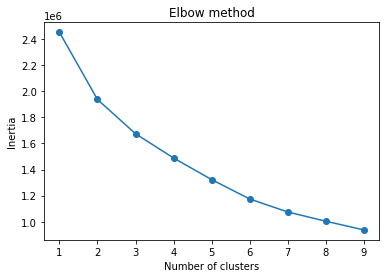

In [122]:
# task 4, marketing customer segmentation

# transactions.
# credit_applications

# new clients

# high-risk clients

# late-payers but payers

# low-risk profiles

# premium clients

# frequent clients

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# data = list(zip(x, y))
data = data.to_numpy()
inertias = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    print(i)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,10), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [126]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

credit_applications['cluster']=kmeans.predict(data)

clusters_characteristics=pd.DataFrame()

clusters_characteristics['price']=credit_applications.groupby('cluster')['price'].mean().values
clusters_characteristics['price_avg_lst3']=credit_applications.groupby('cluster')['price_avg_lst3'].mean()
clusters_characteristics['worst_paymentstatus1']=credit_applications.groupby('cluster')['worst_paymentstatus1'].mean()
clusters_characteristics['worst_paymentstatus_all']=credit_applications.groupby('cluster')['worst_paymentstatus_all'].mean()
clusters_characteristics['count']=credit_applications.groupby('cluster')['count'].mean()
print(clusters_characteristics)
print(credit_applications['cluster'].value_counts(dropna=False))

        price  price_avg_lst3  worst_paymentstatus1  worst_paymentstatus_all  \
0  101.817199       62.458436              0.476286                 1.215205   
1  101.590592      110.522664              0.229523                 0.849087   
2  101.804738      103.107424             -0.259374                -0.259374   
3  101.343659      112.421476              0.515051                 1.376648   

      count  
0  2.221954  
1  4.901515  
2  0.597973  
3  0.948079  
3    165539
2    144918
1    104656
0     75421
Name: cluster, dtype: int64


In [61]:
# print(transactions[transactions['customerID']==2869])
# print(credit_applications[credit_applications['customerID']==2869])

         transactionID  shopID customerID  price  paytmentStatus1  \
0                    1     114       2869    140                0   
689022          689023     579       2869    169                0   
779296          779297     351       2869     39                0   
1167388        1167389     962       2869    156                0   

         paytmentStatus2  paytmentStatus3  paytmentStatus4  
0                      0                0                0  
689022                 0                0                0  
779296                 0                1                0  
1167388                0                0                0  
       transactionID  shopID customerID  price  paytmentStatus1  \
86136        1167389     962       2869    156                0   

       paytmentStatus2  paytmentStatus3  paytmentStatus4   income  
86136                0                0                0  54900.0  


In [52]:
print(x[x['customerID']==2869])

       customerID  transactionID
0            2869              1
689022       2869         689023
779296       2869         779297
